Importing dependencies


In [ ]:
import os
#for reading files of data
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

Defining all alphabet and symbols in Engish Language

In [ ]:
char_list = string.ascii_letters+string.digits
 # we will use this function for each image, we will append each word will occur
def encode_to_labels(txt):
    
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

I have downloade a subset from the main dataset then compressed, uploaded to my Gdrive and then unzipped it, into my colab

In [ ]:
!unzip /content/drive/MyDrive/mjsynth_sample.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: mjsynth_sample/95_Banes_5758.jpg  
  inflating: mjsynth_sample/94_Undisclosed_82317.jpg  
  inflating: mjsynth_sample/93_Affiliating_1411.jpg  
  inflating: mjsynth_sample/92_COEQUALS_14685.jpg  
  inflating: mjsynth_sample/91_Shadowier_69823.jpg  
  inflating: mjsynth_sample/90_acquired_811.jpg  
  inflating: mjsynth_sample/89_snoopier_72273.jpg  
  inflating: mjsynth_sample/88_HUGHES_37216.jpg  
  inflating: mjsynth_sample/87_Depopulates_20746.jpg  
  inflating: mjsynth_sample/86_REVIEWS_65747.jpg  
  inflating: mjsynth_sample/85_Craniums_17804.jpg  
  inflating: mjsynth_sample/84_MISCONCEIVED_48832.jpg  
  inflating: mjsynth_sample/83_philately_57195.jpg  
  inflating: mjsynth_sample/82_Bullfrogs_10133.jpg  
  inflating: mjsynth_sample/81_dengue_20578.jpg  
  inflating: mjsynth_sample/80_preregistering_59794.jpg  
  inflating: mjsynth_sample/79_FOUNDER_30506.jpg  
  inflating: mjsynth_sample/78_millimet

processing and splitting data

In [ ]:
#path of dataset
path = '/content/mjsynth_sample'
 ''' we will split the dataset to validation and training and setting the images and labels for each section into lists'''
 
# lists for training dataset 
training_img = [] # for images
training_txt = [] # labels
train_input_length = [] # maximum length of the text (label)
train_label_length = [] # same
orig_txt = [] # the original text of each image
 
#lists for validation dataset
valid_img = [] # validation images
valid_txt = [] # validation labels
valid_input_length = [] # maximum length of the given string
valid_label_length = [] # also the labels of the dataset
valid_orig_txt = [] 
#  we will calculate the max label length by comparing between this parameter and images of the dataset
max_label_len = 0
# parameters for breaking the loop after finsihing its work
i =1 
flag = 0
 
for root, dirnames, filenames in os.walk(path):
 
    for f_name in fnmatch.filter(filenames, '*.jpg'):
# reading each image and converting to gray Color
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   
 #taking size (height , width) for each image
        w, h = img.shape
        #rezie each image to 128,32
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))
 
        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        
        img = img/255.
        
      # each image name is for example word_23224 so we wanna concatenate the numbers after the text, cuz we wanna take the words in the text
        txt = f_name.split('_')[1]
        # comparison
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
# splitting the data into val and train
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
          # after reaching 5000 images (all the dataset)  the loop must end cuz the dataset ended and the processing finished   
        if i == 5000:
            flag = 1
            break
        i+=1
    if flag == 1:
        break
print(training_img)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Padding for any possible exceeded value

In [ ]:
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list)) 
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

Defining the model

In [ ]:
inputs = Input(shape=(32,128,1))
# first conv is for input 
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
#define CTC loss 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

Compiling the model, saving the model and defining checkpoints

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
#trainig lists
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)
#val lists
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [ ]:
batch_size = 256
epochs = 30
history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/30
18/18 [==============================] - 569s 31s/step - loss: 53.3666 - accuracy: 0.0000e+00 - val_loss: 29.6060 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 29.60599, saving model to best_model.hdf5
Epoch 2/30
18/18 [==============================] - 552s 31s/step - loss: 28.6680 - accuracy: 0.0000e+00 - val_loss: 28.9324 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 29.60599 to 28.93243, saving model to best_model.hdf5
Epoch 3/30
18/18 [==============================] - 555s 31s/step - loss: 28.2412 - accuracy: 0.0000e+00 - val_loss: 29.0123 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 28.93243
Epoch 4/30
18/18 [==============================] - 545s 30s/step - loss: 27.9772 - accuracy: 0.0000e+00 - val_loss: 28.9777 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 28.93243
Epoch 5/30
18/18 [==============================] - 542s 30s/step - loss: 27.6022 - accuracy: 0.0000e+00 - va

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


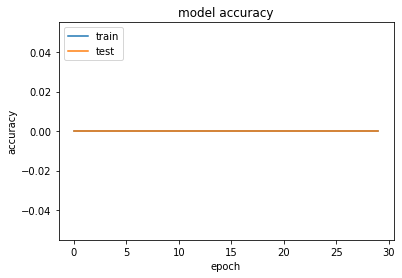

In [ ]:
import matplotlib.pyplot as plt
import numpy
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

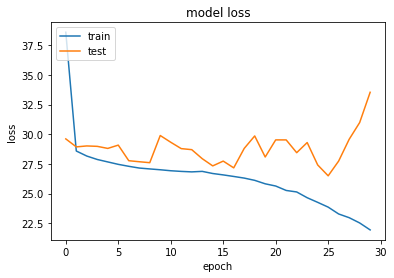

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()